In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tensorflow.keras import layers

In [33]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

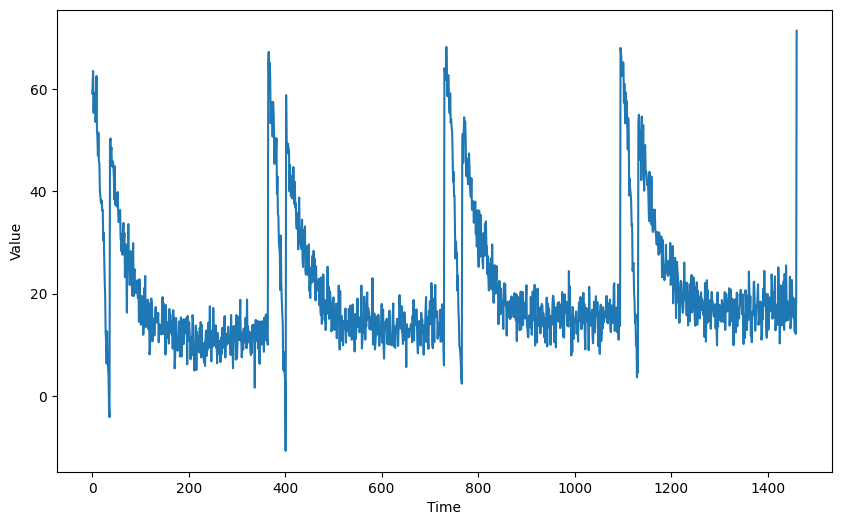

In [34]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000
    

# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

In [35]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [36]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

dataset = windowed_dataset(series_train)

In [37]:
def create_uncompiled_model():

    model = tf.keras.Sequential([
        layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
        layers.Bidirectional(layers.LSTM(128)),
        layers.Dense(1),
        layers.Lambda(lambda x: x * 100.0)
    ])

    return model

In [38]:
def create_model():

    tf.random.set_seed(51)
    
    model = create_uncompiled_model()

    model.compile(optimizer='adam',
                  loss='huber',
                  metrics=["mae"])  
    
    return model

In [39]:
model = create_model()

history = model.fit(dataset, epochs=50)

Epoch 1/50
34/34 [==============================] - 4s 18ms/step - loss: 9.6444 - mae: 10.1342
Epoch 2/50
34/34 [==============================] - 1s 17ms/step - loss: 3.8921 - mae: 4.3643
Epoch 3/50
34/34 [==============================] - 1s 20ms/step - loss: 3.4016 - mae: 3.8729
Epoch 4/50
34/34 [==============================] - 1s 15ms/step - loss: 4.3176 - mae: 4.7990
Epoch 5/50
34/34 [==============================] - 1s 15ms/step - loss: 2.9624 - mae: 3.4270
Epoch 6/50
34/34 [==============================] - 1s 15ms/step - loss: 4.1799 - mae: 4.6543
Epoch 7/50
34/34 [==============================] - 1s 15ms/step - loss: 3.3709 - mae: 3.8420
Epoch 8/50
34/34 [==============================] - 1s 16ms/step - loss: 3.0171 - mae: 3.4820
Epoch 9/50
34/34 [==============================] - 1s 16ms/step - loss: 3.1093 - mae: 3.5768
Epoch 10/50
34/34 [==============================] - 1s 16ms/step - loss: 3.1179 - mae: 3.5856
Epoch 11/50
34/34 [==============================] - 1s 15

In [40]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

In [41]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).cache().prefetch(tf.data.AUTOTUNE)
    
    forecast = model.predict(ds)

    return forecast

12/12 [==============================] - 1s 10ms/step


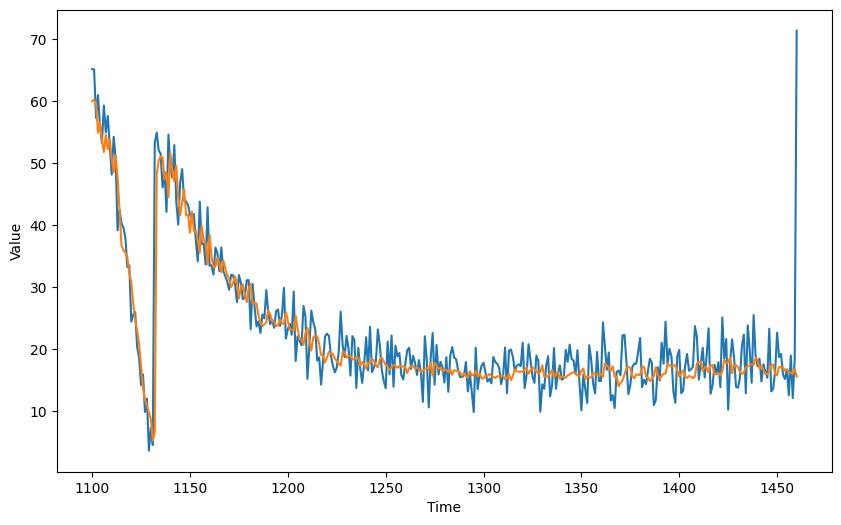

In [42]:
forecast_series = G.SERIES[G.SPLIT_TIME - G.WINDOW_SIZE:-1]
rnn_forecast = model_forecast(model, forecast_series, G.WINDOW_SIZE).squeeze()

plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [43]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 26.81, mae: 3.06 for forecast


In [44]:
# model.save('my_model')